<h1><strong>Weather Prediction Experiment</strong></h1>
<p>In this experiment, we will use the first time step to predict the entire trajectory.</p>

In [1]:
import torch
import os
import h5py
import preprocess
import numpy as np
import matplotlib.pyplot as plt
from utils import SequenceDataset, plot_sample
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn, optim
from pathlib import Path
# Import the necessary classes
from score import ScoreUNet
from score import VPSDE
from score import GaussianScore
import importlib
import score
importlib.reload(score)

<h2>Load Model</h2>

In [ ]:
checkpoint_path = "slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_310.pth"

In [ ]:
import importlib
import score
importlib.reload(score)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PATH_DATA = Path('./data/processed')
# Load mask
with h5py.File(PATH_DATA / "mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32, device=device).unsqueeze(0)
    mask_cpu = mask.detach().clone().cpu()
if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")
window = 12
# Load dataset to get dimensions
testset = SequenceDataset(PATH_DATA / "test.h5", window=window, flatten=True)
channels, y_dim, x_dim = testset[0][0].shape
print(f"Channels : {channels}")

TRAIN_CONFIG = {
    "epochs": 10000,
    "batch_size": 5,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    "activation": "SiLU",
    "eta": 5e-3,
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128,128,256],
'attention_levels' : [2],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : channels,
'context' : 4,
'embedding' : 64 }

Using device: cuda
Channels : 24


In [ ]:
batch_size = TRAIN_CONFIG['batch_size']
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
# Initialize ScoreUNet and VPSDE
score_unet = ScoreUNet(**MODEL_CONFIG).to(device)
vpsde = VPSDE(score_unet, shape=(channels, y_dim, x_dim), eta = TRAIN_CONFIG["eta"]).to(device)
# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
vpsde.load_state_dict(checkpoint['model_state_dict'])
print(f"Model restored from {checkpoint_path}, trained until epoch {checkpoint['epoch']}")

/tmp/ipykernel_766782/3784321478.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Model restored from slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_310.pth, trained until epoch 310


<h2>Define First Time Step Operator A(x)</h2>

In [ ]:
def first_timestep(batch, mask):
    """Extract only the first timestep from the batch and replicate it across all timesteps."""
    if batch.ndim == 4:
        batch = batch.unsqueeze(0)
    S, B, C, H, W = batch.shape
    num_variables = 2  # T2m and U10m
    window = C // num_variables
    batch_reshaped = batch.view(S, B, window, num_variables, H, W)
    first_step = batch_reshaped[:, :, 0, :, :, :]
    expanded = first_step.unsqueeze(2).expand(-1, -1, window, -1, -1, -1)
    return expanded.reshape(S, B, C, H, W) * mask

def A(x):
    return first_timestep(x, mask)

In [ ]:

batch, dic = next(iter(testloader))
batch = batch.to(device)
first_step_data = A(batch)

new_tensor = torch.stack((batch.cpu(), first_step_data.cpu()), dim=1).flatten(0,1).cpu()
path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(new_tensor, info, mask_cpu, samples=4, step=3, unnormalize=True, path_unnorm=path_unnorm)
plt.suptitle("Original Data vs First Timestep Only", fontsize=16)
plt.tight_layout()

RuntimeError: stack expects each tensor to be equal size, but got [5, 24, 64, 64] at entry 0 and [1, 5, 24, 64, 64] at entry 1

<h2>Prediction Experiment</h2>

In [ ]:
x_star, c_star = next(iter(testloader))
x_star = x_star.to(device)
c_star = c_star['context'].to(device)


y_star = torch.normal(A(x_star), 1e-2)*mask  

info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
comparison = torch.stack((x_star.cpu(), y_star.cpu()), dim=1).flatten(0,1).cpu()
fig = plot_sample(comparison, info, mask_cpu, samples=2, step=2, unnormalize=True, path_unnorm=path_unnorm)
plt.suptitle("Ground Truth vs First Timestep Input", fontsize=16)
plt.tight_layout()

torch.Size([5, 24, 64, 64])


ValueError: not enough values to unpack (expected 5, got 4)

In [ ]:
import score
importlib.reload(score)
print('?')
x_star, c_star = next(iter(testloader))
x_star, c_star = x_star[0].unsqueeze(0), c_star['context'][0].unsqueeze(0)
print(x_star.shape, c_star.shape)
x_star = x_star.to(device)
c_star = c_star.to(device)
y_star = torch.normal(A(x_star), 1e-2)*mask  
print(y_star.shape)
sde = VPSDE(score.DPSGaussianScore(y_star, mask, A=A, sde=vpsde, zeta=5.0), shape=x_star.shape).to(device)



?
torch.Size([1, 24, 64, 64]) torch.Size([1, 4, 64, 64])
torch.Size([1, 1, 24, 64, 64])


hello


  2%|▊                                                  | 4/256 [00:01<01:35,  2.64it/s]

100%|█████████████████████████████████████████████████| 256/256 [01:36<00:00,  2.67it/s]


torch.Size([5, 24, 64, 64])
T2m  Mean : 18.003137588500977, Var: 2.2785511016845703
U10m  Mean : 2.2343990802764893, Var: 0.8367398977279663
T2m  Mean : 16.955646514892578, Var: 1.0155019760131836
U10m  Mean : 1.896537184715271, Var: 0.7573042511940002
T2m  Mean : 13.741000175476074, Var: 1.8419972658157349
U10m  Mean : 2.475518226623535, Var: 2.0617594718933105
T2m  Mean : 17.081981658935547, Var: 2.565267562866211
U10m  Mean : 2.2357521057128906, Var: 1.8524131774902344
T2m  Mean : 15.463574409484863, Var: 2.35063099861145
U10m  Mean : 2.216341733932495, Var: 1.9298473596572876


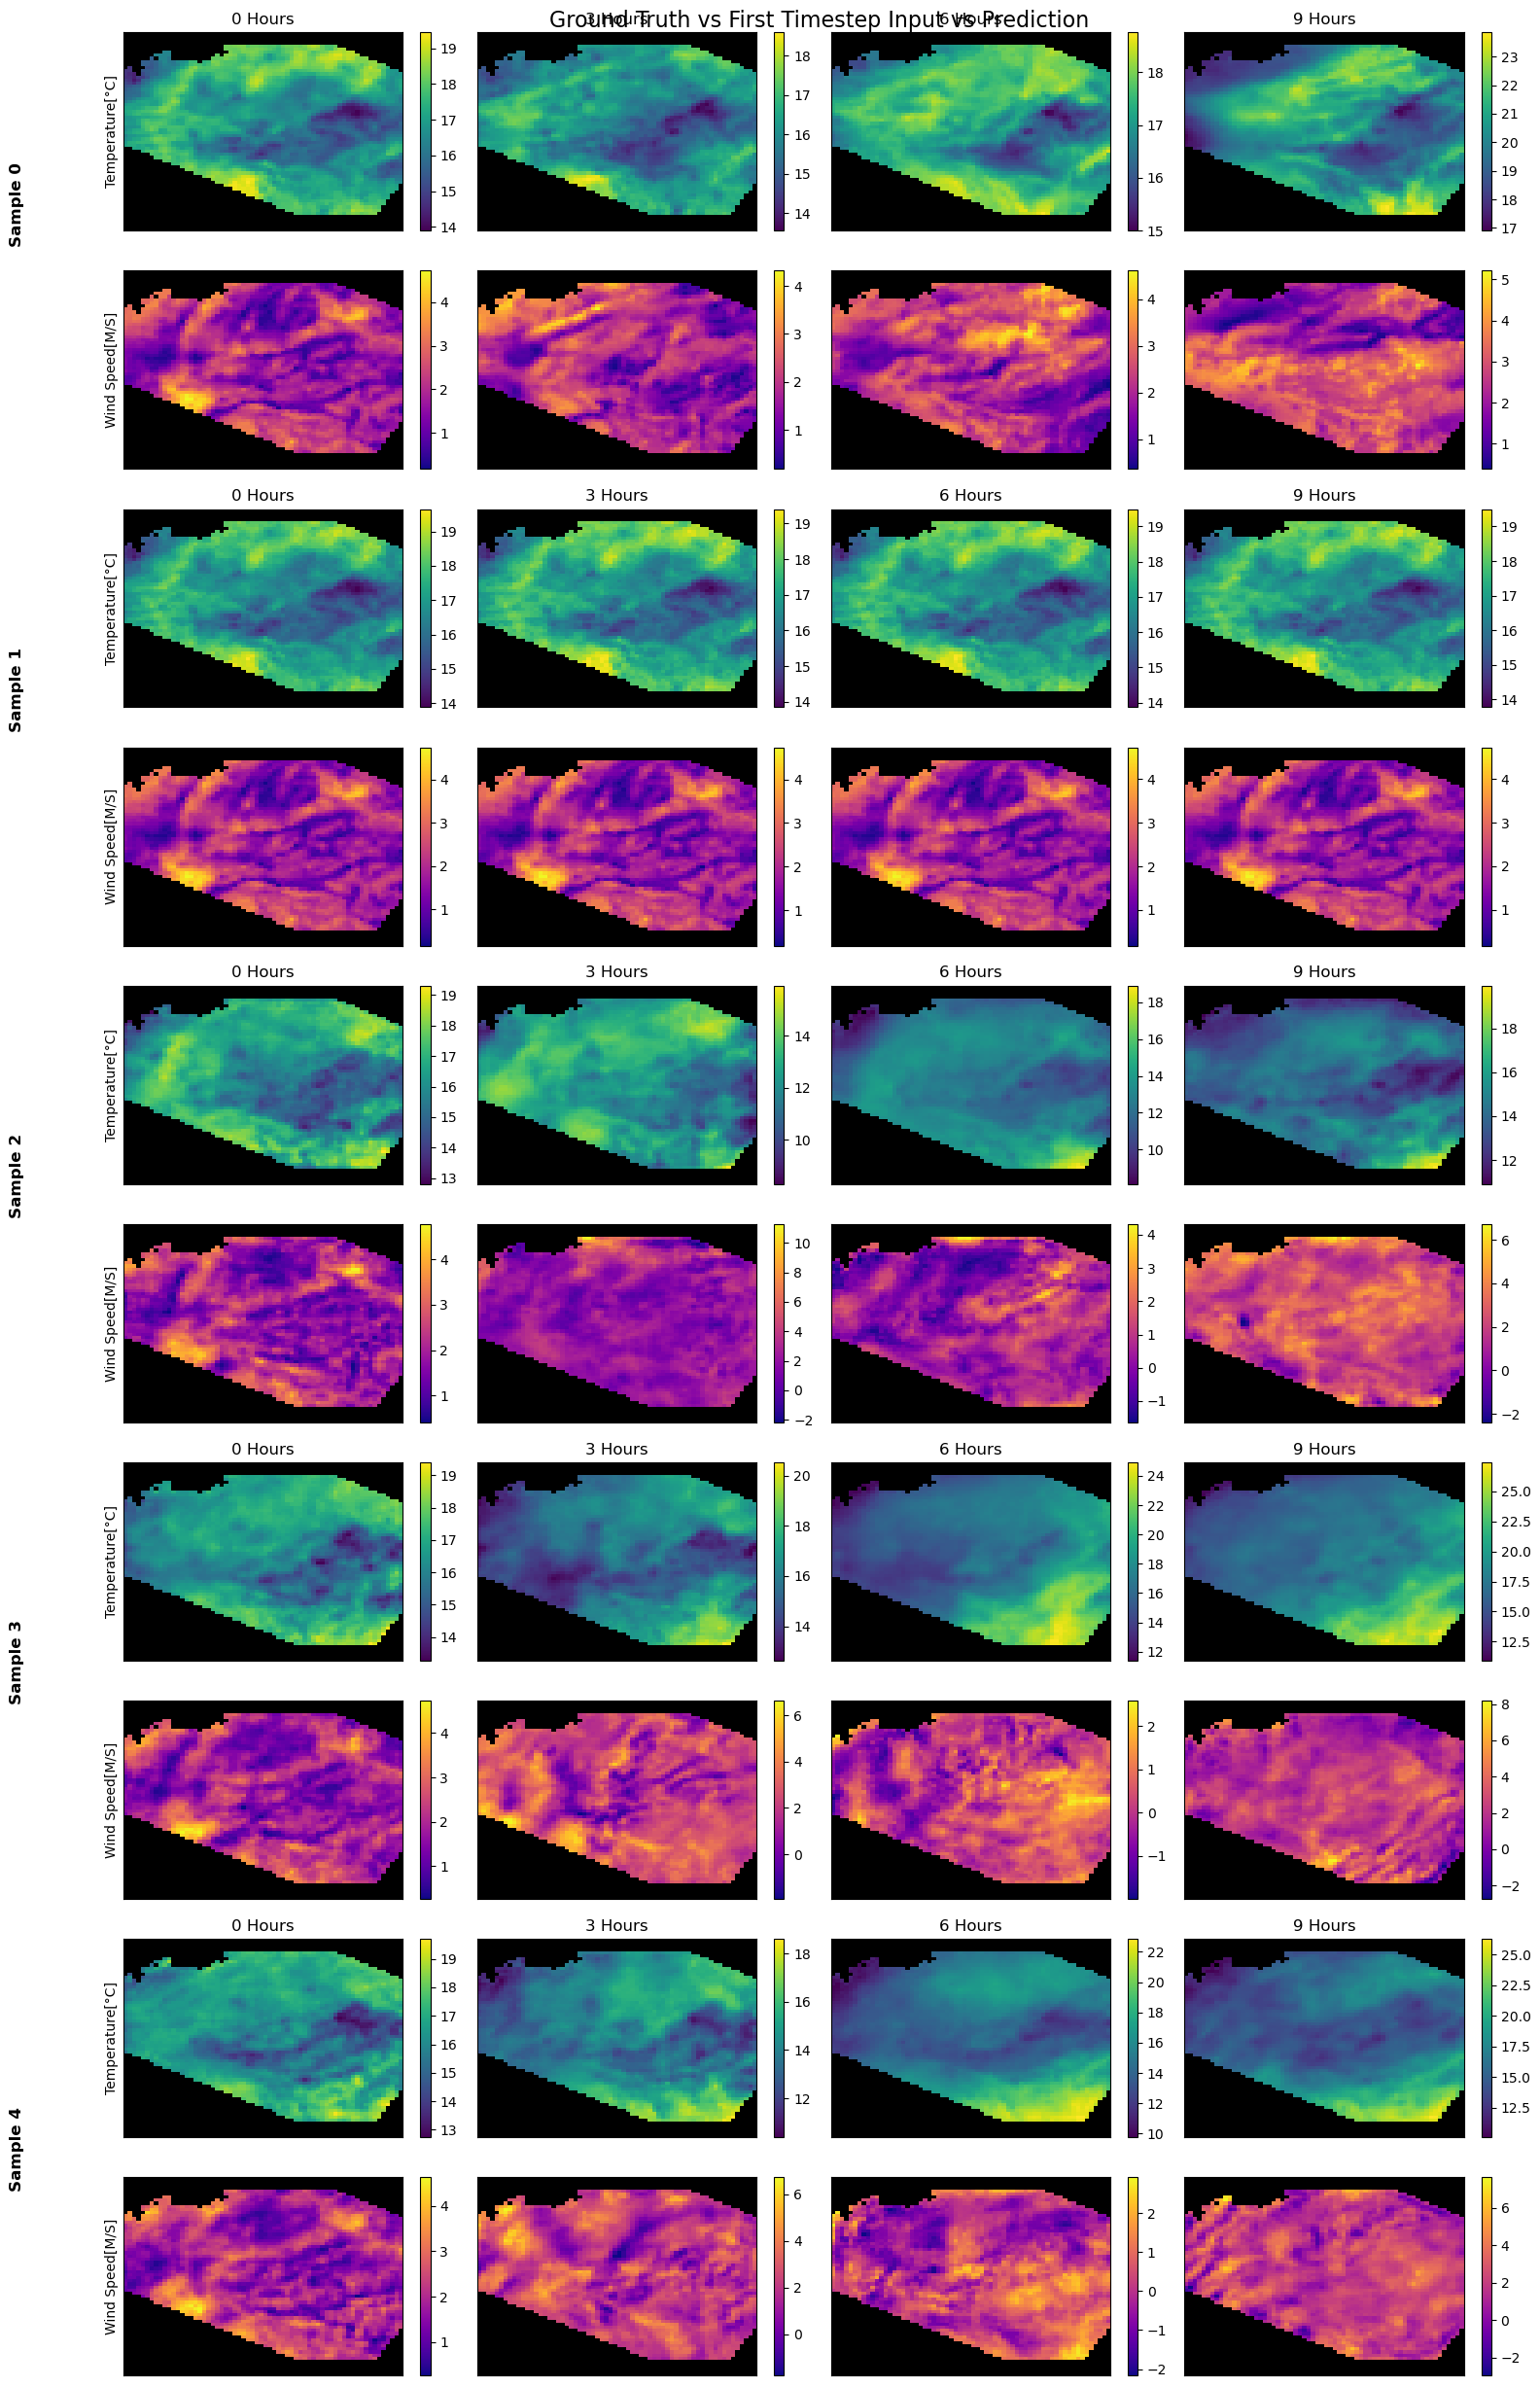

In [ ]:

num_samples = 3
x_preds = sde.sample(mask, shape=(num_samples,), c=c_star, steps=256, corrections=8, tau=0.5).cpu()
all_tensors = [x_star.detach().cpu(), y_star.squeeze(0).detach().cpu()] + [x_preds[i] for i in range(num_samples)]
new_tensor = torch.stack(all_tensors, dim=1).flatten(0,1).cpu()

path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(new_tensor, info, mask_cpu, samples=5, step=3, unnormalize=True, path_unnorm=path_unnorm)
plt.suptitle("Ground Truth vs First Timestep Input vs Prediction", fontsize=16)
plt.tight_layout()

In [ ]:
from metrics import calculate_rmse
preds = torch.stack([x_preds[i] for i in range(num_samples)]).squeeze(1)
gt = x_star.detach().cpu()
gt = gt.repeat(3,1,1,1)
print(preds.shape, gt.shape, mask_cpu.shape)
rmse_per_var_time, overall_rmse = calculate_rmse(preds, gt, mask_cpu)
print(f"Overall RMSE: {overall_rmse:.3f}")
print(f"RMSE per variable and time step: {rmse_per_var_time}")

torch.Size([3, 24, 64, 64]) torch.Size([3, 24, 64, 64]) torch.Size([1, 64, 64])
Overall RMSE: 0.737
RMSE per variable and time step: tensor([[0.2225, 0.3278, 0.3764, 0.6939, 0.5203, 0.8994, 0.6193, 1.1035, 0.7139,
         1.1156, 0.8009, 0.9847],
        [0.8497, 1.8025, 0.9661, 1.7772, 1.1494, 1.1849, 1.2049, 1.1509, 1.1767,
         1.8841, 1.2300, 3.4996]])
